# Multilayer perceptron

This software uses cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline 

See MIT License in 
https://github.com/cauchyturing/UCR_Time_Series_Classification_Deep_Learning_Baseline/README.md

Wang, Z., Yan, W. and Oates, T. (2017) ‘Time series classification from scratch with deep neural networks: A strong baseline’, 2017 International Joint Conference on Neural Networks (IJCNN), pp. 1578–1585 [Online.](https://arxiv.org/abs/1611.06455 "Wang et al. (2017)")

## Formatting

Left align the tables in this Notebook.


In [36]:
%%html
<style>
  table {margin-left: 0 !important;}
</style>

## Data
Additional datasets are available in the UEA & UCT Time Series Classification Repository at http://www.timeseriesclassification.com/. 

Save additional datasets in deepscent/data. E.g. deepscent/data/Adiac/Adiac_TRAIN.txt

### GunPoint dataset
The GunPoint dataset is from the [UEA & UCR Time Series 
Classification Repository](http://www.timeseriesclassification.com/description.php?Dataset=GunPoint 
"GunPoint description"). The data is from one female and one male either drawing and pointing a gun at a target or pointing their finger at a target. The location of their hand was tracked. This data is the time series of the x-axis location.

|Training set size |Test set size |Number of classes 
|:-----------      |:--------     |:----------     
|50 |150  |2 


## Train MLP
Expected running time for various datasets when using the original training/test split. Running on a single NVIDIA GeForce GTX 1080 Ti Graphics Card -

Dataset   | Training time
:-------  | :--------
Adiac     | 18 minutes
GunPoint  | 11 minutes


### User inputs

In [37]:
flist = ['GunPoint'] # List dataset directory names.
k = 4 # For k-fold cross validation. If k=1, the original test-train split is used.
seed = 35 # seed for initialising random weights in the NN.
k_fold_seed = 87
# Directories
fdir = '../data'  
logs_dir = '../logs'
timestamp = '{:%Y-%m-%dT%H:%M}'.format(datetime.now())
logs_dir = logs_dir +'/' + timestamp

### Set up

In [38]:
import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.callbacks import ReduceLROnPlateau

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

import os
import time
from datetime import datetime
import pathlib

np.random.seed(22)#813306)

      
def readucr(filename):
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y
  
nb_epochs = 5000

### Visualise the data

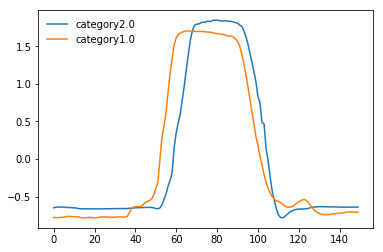

In [39]:
fname = flist[0]
data_a = 0
data_b = 2
x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
plt.plot(x_train[data_a], label='category'+str(y_train[data_a]))
plt.plot(x_train[data_b], label='category'+str(y_train[data_b]))
plt.legend(loc='upper left', frameon=False)

### Function to train the MLP

In [40]:
def train_model(fname, x_train, y_train, x_test, y_test):
    print('Running dataset', fname)
    nb_classes =len(np.unique(y_test))
    y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
    y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)
    batch_size = int(min(x_train.shape[0]/10, 16))
    
    Y_train = utils.to_categorical(y_train, nb_classes)
    Y_test = utils.to_categorical(y_test, nb_classes)
     
    x_train_mean = x_train.mean()
    x_train_std = x_train.std()
    x_train = (x_train - x_train_mean)/(x_train_std)
     
   # x_test_min = np.min(x_test, axis = 1, keepdims=1)
   # x_test_max = np.max(x_test, axis = 1, keepdims=1)
    x_test = (x_test - x_train_mean)/(x_train_std)
     
    #x_train = x_train.reshape(x_train.shape + (1,))
    #x_test = x_test.reshape(x_test.shape + (1,))
    
    x = Input(x_train.shape[1:])
    y= Dropout(0.1)(x)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(x)
    y = Dropout(0.2)(y)
    y = Dense(500, activation='relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.2)(y)
    y = Dense(500, activation = 'relu', kernel_initializer=RandomUniform(seed=seed))(y)
    y = Dropout(0.3)(y)
    out = Dense(nb_classes, activation='softmax', kernel_initializer=RandomUniform(seed=seed))(y)
     
    model = Model(x, out)
     
    optimizer = keras.optimizers.Adadelta(rho=0.95, epsilon=1e-8)  
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
     
    reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor=0.5,
                      patience=200, min_lr=0.1)
    

    start = time.time()
    hist = model.fit(x_train, Y_train, batch_size=batch_size, epochs=nb_epochs,
              verbose=2, validation_data=(x_test, Y_test), 
                #callbacks = [TestCallback((x_train, Y_train)), reduce_lr, keras.callbacks.TensorBoard(log_dir='./log'+fname, histogram_freq=1)])
                 callbacks=[reduce_lr])
    end = time.time()
    
    log = pd.DataFrame(hist.history)
    # Print results. Print the testing results which has the lowest training loss.
    print('Training complete on', fname)
    print('Training time ', end-start, 'seconds, which is about', round((end-start)/60), 'minutes.')
    print('Selected the test result with the lowest training loss. Loss and accuracy are -')
    loss = log.loc[log['loss'].idxmin]['loss']
    val_acc = log.loc[log['loss'].idxmin]['val_acc']
    print(loss, val_acc)
    print('For the results table -')
    print('|#   |',loss,'  |',val_acc,' |', ' .|', timestamp, '  |')
    # Save log file.
    pathlib.Path(logs_dir+'/'+fname).mkdir(parents=True, exist_ok=True) 
    print('Saving logs to',logs_dir+'/'+fname+'/history.csv')
    log.to_csv(logs_dir+'/'+fname+'/history.csv')
 



# Train

In [41]:
for each in flist:
    fname = each
    x_train, y_train = readucr(fdir+'/'+fname+'/'+fname+'_TRAIN.txt')
    x_test, y_test = readucr(fdir+'/'+fname+'/'+fname+'_TEST.txt')
    # k-fold cross validation setup
    if k > 1:
        x_all = np.concatenate((x_train, x_test), axis=0)
        y_all = np.concatenate((y_train, y_test), axis=0)
        kfold = KFold(k, True, k_fold_seed)
        for train, test in kfold.split(x_all):
            x_train, y_train, x_test, y_test = x_all[train], y_all[train], x_all[test], y_all[test]
            train_model(fname, x_train, x_test, y_train, y_test)
    else:
        train_model(fname, x_train, y_train, x_test, y_test)
	

Running dataset GunPoint
Train on 50 samples, validate on 150 samples
Epoch 1/5000
50/50 [==============================] - 2s 39ms/step - loss: 0.6908 - acc: 0.5000 - val_loss: 0.6752 - val_acc: 0.4933
Epoch 2/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.6505 - acc: 0.6000 - val_loss: 0.6114 - val_acc: 0.6733
Epoch 3/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.5134 - acc: 0.7800 - val_loss: 0.5426 - val_acc: 0.6467
Epoch 4/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.5200 - acc: 0.7600 - val_loss: 0.4638 - val_acc: 0.7333
Epoch 5/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.3922 - acc: 0.8800 - val_loss: 0.6271 - val_acc: 0.7067
Epoch 6/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.3651 - acc: 0.8400 - val_loss: 0.4213 - val_acc: 0.7533
Epoch 7/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.2980 - acc: 0.8400 - val_loss: 0.4223 - val_acc: 0.7800
Epoch

50/50 [==============================] - 0s 3ms/step - loss: 0.0696 - acc: 0.9800 - val_loss: 0.4614 - val_acc: 0.8733
Epoch 63/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0453 - acc: 0.9800 - val_loss: 0.3144 - val_acc: 0.9067
Epoch 64/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0341 - acc: 1.0000 - val_loss: 0.3103 - val_acc: 0.9200
Epoch 65/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0197 - acc: 1.0000 - val_loss: 0.2961 - val_acc: 0.9067
Epoch 66/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0293 - acc: 0.9800 - val_loss: 0.3074 - val_acc: 0.9067
Epoch 67/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0844 - acc: 0.9800 - val_loss: 0.3928 - val_acc: 0.9000
Epoch 68/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0105 - acc: 1.0000 - val_loss: 0.3214 - val_acc: 0.9133
Epoch 69/5000
50/50 [==============================] - 0s 3ms/step - loss: 0.0076 -

50/50 [==============================] - 0s 2ms/step - loss: 3.8676e-04 - acc: 1.0000 - val_loss: 0.4494 - val_acc: 0.9133
Epoch 124/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.1156e-04 - acc: 1.0000 - val_loss: 0.3855 - val_acc: 0.9267
Epoch 125/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0118 - acc: 1.0000 - val_loss: 0.3909 - val_acc: 0.9333
Epoch 126/5000
50/50 [==============================] - 0s 2ms/step - loss: 0.0012 - acc: 1.0000 - val_loss: 0.4935 - val_acc: 0.9067
Epoch 127/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.8431e-04 - acc: 1.0000 - val_loss: 0.4085 - val_acc: 0.9333
Epoch 128/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.7424e-04 - acc: 1.0000 - val_loss: 0.4248 - val_acc: 0.9200
Epoch 129/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.5383e-04 - acc: 1.0000 - val_loss: 0.4183 - val_acc: 0.9267
Epoch 130/5000
50/50 [==============================] - 0

Epoch 183/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.9388e-05 - acc: 1.0000 - val_loss: 0.5033 - val_acc: 0.9400
Epoch 184/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.9417e-05 - acc: 1.0000 - val_loss: 0.5045 - val_acc: 0.9400
Epoch 185/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.0519e-05 - acc: 1.0000 - val_loss: 0.5213 - val_acc: 0.9267
Epoch 186/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.2143e-05 - acc: 1.0000 - val_loss: 0.5099 - val_acc: 0.9400
Epoch 187/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0651e-04 - acc: 1.0000 - val_loss: 0.5045 - val_acc: 0.9267
Epoch 188/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.1182e-05 - acc: 1.0000 - val_loss: 0.5065 - val_acc: 0.9333
Epoch 189/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.2643e-05 - acc: 1.0000 - val_loss: 0.5256 - val_acc: 0.9333
Epoch 190/5000
50/50 [============

50/50 [==============================] - 0s 3ms/step - loss: 5.5672e-05 - acc: 1.0000 - val_loss: 0.5752 - val_acc: 0.9267
Epoch 243/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3239e-05 - acc: 1.0000 - val_loss: 0.5784 - val_acc: 0.9267
Epoch 244/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.0077e-05 - acc: 1.0000 - val_loss: 0.5617 - val_acc: 0.9267
Epoch 245/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.0847e-05 - acc: 1.0000 - val_loss: 0.5695 - val_acc: 0.9267
Epoch 246/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.8090e-05 - acc: 1.0000 - val_loss: 0.5809 - val_acc: 0.9267
Epoch 247/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.3464e-05 - acc: 1.0000 - val_loss: 0.5781 - val_acc: 0.9267
Epoch 248/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.6917e-04 - acc: 1.0000 - val_loss: 0.5341 - val_acc: 0.9267
Epoch 249/5000
50/50 [===========================

50/50 [==============================] - 0s 2ms/step - loss: 0.0178 - acc: 1.0000 - val_loss: 0.6581 - val_acc: 0.9067
Epoch 302/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0916e-05 - acc: 1.0000 - val_loss: 0.6573 - val_acc: 0.9067
Epoch 303/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.6999e-04 - acc: 1.0000 - val_loss: 0.6390 - val_acc: 0.9133
Epoch 304/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.3033e-06 - acc: 1.0000 - val_loss: 0.6391 - val_acc: 0.9133
Epoch 305/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.2611e-04 - acc: 1.0000 - val_loss: 0.5914 - val_acc: 0.9200
Epoch 306/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2282e-04 - acc: 1.0000 - val_loss: 0.5828 - val_acc: 0.9200
Epoch 307/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.9238e-06 - acc: 1.0000 - val_loss: 0.5824 - val_acc: 0.9200
Epoch 308/5000
50/50 [==============================]

50/50 [==============================] - 0s 3ms/step - loss: 1.1792e-05 - acc: 1.0000 - val_loss: 0.7876 - val_acc: 0.9067
Epoch 361/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.3147e-05 - acc: 1.0000 - val_loss: 0.7858 - val_acc: 0.9067
Epoch 362/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.2973e-05 - acc: 1.0000 - val_loss: 0.7753 - val_acc: 0.9067
Epoch 363/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.2760e-05 - acc: 1.0000 - val_loss: 0.7602 - val_acc: 0.9067
Epoch 364/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.5622e-05 - acc: 1.0000 - val_loss: 0.7371 - val_acc: 0.9067
Epoch 365/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.4936e-05 - acc: 1.0000 - val_loss: 0.7174 - val_acc: 0.9133
Epoch 366/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0127e-04 - acc: 1.0000 - val_loss: 0.6722 - val_acc: 0.9133
Epoch 367/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 8.1376e-06 - acc: 1.0000 - val_loss: 0.6572 - val_acc: 0.9200
Epoch 420/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.7931e-05 - acc: 1.0000 - val_loss: 0.6558 - val_acc: 0.9200
Epoch 421/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.3039e-06 - acc: 1.0000 - val_loss: 0.6498 - val_acc: 0.9200
Epoch 422/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.5154e-06 - acc: 1.0000 - val_loss: 0.6503 - val_acc: 0.9200
Epoch 423/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.1588e-05 - acc: 1.0000 - val_loss: 0.6229 - val_acc: 0.9333
Epoch 424/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.4465e-06 - acc: 1.0000 - val_loss: 0.6262 - val_acc: 0.9267
Epoch 425/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.6398e-04 - acc: 1.0000 - val_loss: 0.8874 - val_acc: 0.8933
Epoch 426/5000
50/50 [===========================

50/50 [==============================] - 0s 2ms/step - loss: 9.2885e-06 - acc: 1.0000 - val_loss: 0.6505 - val_acc: 0.9333
Epoch 479/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.7367e-04 - acc: 1.0000 - val_loss: 0.6019 - val_acc: 0.9400
Epoch 480/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.3411e-06 - acc: 1.0000 - val_loss: 0.6046 - val_acc: 0.9333
Epoch 481/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0908e-06 - acc: 1.0000 - val_loss: 0.6048 - val_acc: 0.9333
Epoch 482/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.6904e-07 - acc: 1.0000 - val_loss: 0.6051 - val_acc: 0.9333
Epoch 483/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.1388e-05 - acc: 1.0000 - val_loss: 0.6167 - val_acc: 0.9267
Epoch 484/5000
50/50 [==============================] - 0s 2ms/step - loss: 9.0123e-07 - acc: 1.0000 - val_loss: 0.6167 - val_acc: 0.9267
Epoch 485/5000
50/50 [===========================

50/50 [==============================] - 0s 2ms/step - loss: 1.5069e-04 - acc: 1.0000 - val_loss: 0.6166 - val_acc: 0.9400
Epoch 538/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.2112e-06 - acc: 1.0000 - val_loss: 0.6172 - val_acc: 0.9400
Epoch 539/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.8180e-06 - acc: 1.0000 - val_loss: 0.6180 - val_acc: 0.9400
Epoch 540/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.0805e-06 - acc: 1.0000 - val_loss: 0.6157 - val_acc: 0.9400
Epoch 541/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.9561e-06 - acc: 1.0000 - val_loss: 0.6181 - val_acc: 0.9400
Epoch 542/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1993e-06 - acc: 1.0000 - val_loss: 0.6186 - val_acc: 0.9400
Epoch 543/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.0290e-06 - acc: 1.0000 - val_loss: 0.6196 - val_acc: 0.9400
Epoch 544/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 1.3471e-06 - acc: 1.0000 - val_loss: 0.6468 - val_acc: 0.9333
Epoch 597/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.1134e-06 - acc: 1.0000 - val_loss: 0.6594 - val_acc: 0.9333
Epoch 598/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0800e-06 - acc: 1.0000 - val_loss: 0.6591 - val_acc: 0.9333
Epoch 599/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1182e-06 - acc: 1.0000 - val_loss: 0.6571 - val_acc: 0.9333
Epoch 600/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.8108e-06 - acc: 1.0000 - val_loss: 0.6540 - val_acc: 0.9333
Epoch 601/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.9982e-06 - acc: 1.0000 - val_loss: 0.6465 - val_acc: 0.9333
Epoch 602/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.2837e-07 - acc: 1.0000 - val_loss: 0.6463 - val_acc: 0.9333
Epoch 603/5000
50/50 [===========================

50/50 [==============================] - 0s 2ms/step - loss: 3.2879e-06 - acc: 1.0000 - val_loss: 0.6528 - val_acc: 0.9333
Epoch 656/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.2493e-07 - acc: 1.0000 - val_loss: 0.6519 - val_acc: 0.9333
Epoch 657/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.0095e-07 - acc: 1.0000 - val_loss: 0.6517 - val_acc: 0.9333
Epoch 658/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.5460e-07 - acc: 1.0000 - val_loss: 0.6518 - val_acc: 0.9333
Epoch 659/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2851e-06 - acc: 1.0000 - val_loss: 0.6522 - val_acc: 0.9333
Epoch 660/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5772e-06 - acc: 1.0000 - val_loss: 0.6513 - val_acc: 0.9333
Epoch 661/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.3447e-07 - acc: 1.0000 - val_loss: 0.6518 - val_acc: 0.9333
Epoch 662/5000
50/50 [===========================

50/50 [==============================] - 0s 2ms/step - loss: 5.1831e-05 - acc: 1.0000 - val_loss: 0.7130 - val_acc: 0.9067
Epoch 715/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.4919e-06 - acc: 1.0000 - val_loss: 0.7017 - val_acc: 0.9133
Epoch 716/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1767e-05 - acc: 1.0000 - val_loss: 0.6816 - val_acc: 0.9200
Epoch 717/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.2306e-07 - acc: 1.0000 - val_loss: 0.6815 - val_acc: 0.9200
Epoch 718/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.4486e-06 - acc: 1.0000 - val_loss: 0.6823 - val_acc: 0.9200
Epoch 719/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.9731e-06 - acc: 1.0000 - val_loss: 0.6749 - val_acc: 0.9333
Epoch 720/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.8051e-06 - acc: 1.0000 - val_loss: 0.6708 - val_acc: 0.9333
Epoch 721/5000
50/50 [===========================

50/50 [==============================] - 0s 2ms/step - loss: 1.6988e-06 - acc: 1.0000 - val_loss: 0.6584 - val_acc: 0.9333
Epoch 774/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.4332e-07 - acc: 1.0000 - val_loss: 0.6584 - val_acc: 0.9333
Epoch 775/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.3764e-07 - acc: 1.0000 - val_loss: 0.6581 - val_acc: 0.9333
Epoch 776/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.6456e-06 - acc: 1.0000 - val_loss: 0.6628 - val_acc: 0.9333
Epoch 777/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.7670e-07 - acc: 1.0000 - val_loss: 0.6627 - val_acc: 0.9333
Epoch 778/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.2495e-06 - acc: 1.0000 - val_loss: 0.6637 - val_acc: 0.9333
Epoch 779/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.9062e-06 - acc: 1.0000 - val_loss: 0.6652 - val_acc: 0.9333
Epoch 780/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 4.4704e-07 - acc: 1.0000 - val_loss: 0.6856 - val_acc: 0.9200
Epoch 833/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.4057e-06 - acc: 1.0000 - val_loss: 0.6836 - val_acc: 0.9200
Epoch 834/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.2374e-06 - acc: 1.0000 - val_loss: 0.6828 - val_acc: 0.9200
Epoch 835/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1814e-06 - acc: 1.0000 - val_loss: 0.6811 - val_acc: 0.9200
Epoch 836/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.1306e-06 - acc: 1.0000 - val_loss: 0.6769 - val_acc: 0.9200
Epoch 837/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.4353e-06 - acc: 1.0000 - val_loss: 0.6774 - val_acc: 0.9200
Epoch 838/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.0288e-05 - acc: 1.0000 - val_loss: 0.6553 - val_acc: 0.9333
Epoch 839/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 6.5685e-07 - acc: 1.0000 - val_loss: 0.6664 - val_acc: 0.9333
Epoch 892/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.9491e-06 - acc: 1.0000 - val_loss: 0.6660 - val_acc: 0.9333
Epoch 893/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.0426e-07 - acc: 1.0000 - val_loss: 0.6661 - val_acc: 0.9333
Epoch 894/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.8066e-04 - acc: 1.0000 - val_loss: 0.6533 - val_acc: 0.9333
Epoch 895/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.3539e-07 - acc: 1.0000 - val_loss: 0.6533 - val_acc: 0.9333
Epoch 896/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.2493e-07 - acc: 1.0000 - val_loss: 0.6534 - val_acc: 0.9333
Epoch 897/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.1035e-07 - acc: 1.0000 - val_loss: 0.6534 - val_acc: 0.9333
Epoch 898/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 4.8757e-07 - acc: 1.0000 - val_loss: 0.6665 - val_acc: 0.9333
Epoch 951/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.7909e-07 - acc: 1.0000 - val_loss: 0.6663 - val_acc: 0.9333
Epoch 952/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.4360e-07 - acc: 1.0000 - val_loss: 0.6663 - val_acc: 0.9333
Epoch 953/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.9660e-07 - acc: 1.0000 - val_loss: 0.6665 - val_acc: 0.9333
Epoch 954/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.0994e-07 - acc: 1.0000 - val_loss: 0.6664 - val_acc: 0.9333
Epoch 955/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.4866e-06 - acc: 1.0000 - val_loss: 0.6666 - val_acc: 0.9333
Epoch 956/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.3380e-06 - acc: 1.0000 - val_loss: 0.6678 - val_acc: 0.9333
Epoch 957/5000
50/50 [===========================

50/50 [==============================] - 0s 3ms/step - loss: 8.8241e-06 - acc: 1.0000 - val_loss: 0.6641 - val_acc: 0.9333
Epoch 1010/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.8370e-06 - acc: 1.0000 - val_loss: 0.6636 - val_acc: 0.9333
Epoch 1011/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.5712e-06 - acc: 1.0000 - val_loss: 0.6640 - val_acc: 0.9333
Epoch 1012/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.9892e-06 - acc: 1.0000 - val_loss: 0.6693 - val_acc: 0.9333
Epoch 1013/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.5009e-06 - acc: 1.0000 - val_loss: 0.6703 - val_acc: 0.9333
Epoch 1014/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.9724e-07 - acc: 1.0000 - val_loss: 0.6705 - val_acc: 0.9333
Epoch 1015/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.4639e-07 - acc: 1.0000 - val_loss: 0.6705 - val_acc: 0.9333
Epoch 1016/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 2.1676e-05 - acc: 1.0000 - val_loss: 0.7028 - val_acc: 0.9200
Epoch 1069/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1861e-06 - acc: 1.0000 - val_loss: 0.7024 - val_acc: 0.9200
Epoch 1070/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5784e-06 - acc: 1.0000 - val_loss: 0.7027 - val_acc: 0.9200
Epoch 1071/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.7393e-06 - acc: 1.0000 - val_loss: 0.7019 - val_acc: 0.9200
Epoch 1072/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1098e-06 - acc: 1.0000 - val_loss: 0.7013 - val_acc: 0.9200
Epoch 1073/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.0663e-06 - acc: 1.0000 - val_loss: 0.6990 - val_acc: 0.9200
Epoch 1074/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.7102e-07 - acc: 1.0000 - val_loss: 0.6987 - val_acc: 0.9200
Epoch 1075/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 6.9261e-07 - acc: 1.0000 - val_loss: 0.6663 - val_acc: 0.9333
Epoch 1128/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.7248e-07 - acc: 1.0000 - val_loss: 0.6665 - val_acc: 0.9333
Epoch 1129/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0681e-06 - acc: 1.0000 - val_loss: 0.6668 - val_acc: 0.9333
Epoch 1130/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.9315e-06 - acc: 1.0000 - val_loss: 0.6655 - val_acc: 0.9333
Epoch 1131/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.7059e-06 - acc: 1.0000 - val_loss: 0.6647 - val_acc: 0.9333
Epoch 1132/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.4854e-06 - acc: 1.0000 - val_loss: 0.6642 - val_acc: 0.9333
Epoch 1133/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.0572e-07 - acc: 1.0000 - val_loss: 0.6644 - val_acc: 0.9333
Epoch 1134/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 5.1181e-06 - acc: 1.0000 - val_loss: 0.6703 - val_acc: 0.9333
Epoch 1187/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5772e-06 - acc: 1.0000 - val_loss: 0.6698 - val_acc: 0.9333
Epoch 1188/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.7830e-07 - acc: 1.0000 - val_loss: 0.6697 - val_acc: 0.9333
Epoch 1189/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.2599e-07 - acc: 1.0000 - val_loss: 0.6698 - val_acc: 0.9333
Epoch 1190/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.8454e-07 - acc: 1.0000 - val_loss: 0.6700 - val_acc: 0.9333
Epoch 1191/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2758e-06 - acc: 1.0000 - val_loss: 0.6705 - val_acc: 0.9333
Epoch 1192/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.8517e-06 - acc: 1.0000 - val_loss: 0.6687 - val_acc: 0.9333
Epoch 1193/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.3471e-06 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 0.9333
Epoch 1246/5000
50/50 [==============================] - 0s 2ms/step - loss: 9.7514e-07 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 0.9333
Epoch 1247/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.7950e-07 - acc: 1.0000 - val_loss: 0.6780 - val_acc: 0.9333
Epoch 1248/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.5738e-06 - acc: 1.0000 - val_loss: 0.6774 - val_acc: 0.9333
Epoch 1249/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5915e-06 - acc: 1.0000 - val_loss: 0.6782 - val_acc: 0.9333
Epoch 1250/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1695e-06 - acc: 1.0000 - val_loss: 0.6786 - val_acc: 0.9333
Epoch 1251/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.4997e-07 - acc: 1.0000 - val_loss: 0.6789 - val_acc: 0.9333
Epoch 1252/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.0042e-06 - acc: 1.0000 - val_loss: 0.6797 - val_acc: 0.9333
Epoch 1305/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.4997e-06 - acc: 1.0000 - val_loss: 0.6792 - val_acc: 0.9333
Epoch 1306/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.6976e-06 - acc: 1.0000 - val_loss: 0.6785 - val_acc: 0.9333
Epoch 1307/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1039e-06 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 0.9333
Epoch 1308/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.0930e-07 - acc: 1.0000 - val_loss: 0.6780 - val_acc: 0.9333
Epoch 1309/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.1434e-07 - acc: 1.0000 - val_loss: 0.6776 - val_acc: 0.9333
Epoch 1310/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.9247e-07 - acc: 1.0000 - val_loss: 0.6774 - val_acc: 0.9333
Epoch 1311/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 7.2122e-07 - acc: 1.0000 - val_loss: 0.6795 - val_acc: 0.9333
Epoch 1364/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.2360e-07 - acc: 1.0000 - val_loss: 0.6792 - val_acc: 0.9333
Epoch 1365/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1885e-06 - acc: 1.0000 - val_loss: 0.6793 - val_acc: 0.9333
Epoch 1366/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.6029e-07 - acc: 1.0000 - val_loss: 0.6793 - val_acc: 0.9333
Epoch 1367/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.1485e-07 - acc: 1.0000 - val_loss: 0.6793 - val_acc: 0.9333
Epoch 1368/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.9062e-06 - acc: 1.0000 - val_loss: 0.6791 - val_acc: 0.9333
Epoch 1369/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.9394e-07 - acc: 1.0000 - val_loss: 0.6788 - val_acc: 0.9333
Epoch 1370/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.7882e-06 - acc: 1.0000 - val_loss: 0.6726 - val_acc: 0.9333
Epoch 1423/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.6652e-07 - acc: 1.0000 - val_loss: 0.6728 - val_acc: 0.9333
Epoch 1424/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.8069e-07 - acc: 1.0000 - val_loss: 0.6728 - val_acc: 0.9333
Epoch 1425/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1349e-06 - acc: 1.0000 - val_loss: 0.6728 - val_acc: 0.9333
Epoch 1426/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1730e-06 - acc: 1.0000 - val_loss: 0.6733 - val_acc: 0.9333
Epoch 1427/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.6284e-06 - acc: 1.0000 - val_loss: 0.6761 - val_acc: 0.9333
Epoch 1428/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.4162e-07 - acc: 1.0000 - val_loss: 0.6763 - val_acc: 0.9333
Epoch 1429/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 6.5088e-07 - acc: 1.0000 - val_loss: 0.6635 - val_acc: 0.9333
Epoch 1482/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.2517e-06 - acc: 1.0000 - val_loss: 0.6640 - val_acc: 0.9333
Epoch 1483/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.5321e-06 - acc: 1.0000 - val_loss: 0.6647 - val_acc: 0.9333
Epoch 1484/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.8069e-07 - acc: 1.0000 - val_loss: 0.6646 - val_acc: 0.9333
Epoch 1485/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5152e-06 - acc: 1.0000 - val_loss: 0.6645 - val_acc: 0.9333
Epoch 1486/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.2708e-06 - acc: 1.0000 - val_loss: 0.6644 - val_acc: 0.9333
Epoch 1487/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.4317e-06 - acc: 1.0000 - val_loss: 0.6647 - val_acc: 0.9333
Epoch 1488/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 2.8457e-06 - acc: 1.0000 - val_loss: 0.6847 - val_acc: 0.9333
Epoch 1541/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.1175e-05 - acc: 1.0000 - val_loss: 0.6682 - val_acc: 0.9333
Epoch 1542/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.1141e-07 - acc: 1.0000 - val_loss: 0.6682 - val_acc: 0.9333
Epoch 1543/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.8413e-07 - acc: 1.0000 - val_loss: 0.6682 - val_acc: 0.9333
Epoch 1544/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.6240e-07 - acc: 1.0000 - val_loss: 0.6682 - val_acc: 0.9333
Epoch 1545/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.3406e-07 - acc: 1.0000 - val_loss: 0.6681 - val_acc: 0.9333
Epoch 1546/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.1706e-06 - acc: 1.0000 - val_loss: 0.6664 - val_acc: 0.9333
Epoch 1547/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.9578e-07 - acc: 1.0000 - val_loss: 0.6733 - val_acc: 0.9333
Epoch 1600/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.9353e-07 - acc: 1.0000 - val_loss: 0.6733 - val_acc: 0.9333
Epoch 1601/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1408e-06 - acc: 1.0000 - val_loss: 0.6734 - val_acc: 0.9333
Epoch 1602/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.3594e-06 - acc: 1.0000 - val_loss: 0.6726 - val_acc: 0.9333
Epoch 1603/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.7238e-06 - acc: 1.0000 - val_loss: 0.6717 - val_acc: 0.9333
Epoch 1604/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.6240e-07 - acc: 1.0000 - val_loss: 0.6717 - val_acc: 0.9333
Epoch 1605/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.1989e-07 - acc: 1.0000 - val_loss: 0.6715 - val_acc: 0.9333
Epoch 1606/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.6630e-06 - acc: 1.0000 - val_loss: 0.6797 - val_acc: 0.9333
Epoch 1659/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.0334e-07 - acc: 1.0000 - val_loss: 0.6800 - val_acc: 0.9333
Epoch 1660/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.6771e-07 - acc: 1.0000 - val_loss: 0.6801 - val_acc: 0.9333
Epoch 1661/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.3328e-06 - acc: 1.0000 - val_loss: 0.6801 - val_acc: 0.9333
Epoch 1662/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.8424e-06 - acc: 1.0000 - val_loss: 0.6775 - val_acc: 0.9333
Epoch 1663/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.9922e-07 - acc: 1.0000 - val_loss: 0.6775 - val_acc: 0.9333
Epoch 1664/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.8871e-06 - acc: 1.0000 - val_loss: 0.6767 - val_acc: 0.9333
Epoch 1665/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 7.9632e-07 - acc: 1.0000 - val_loss: 0.6773 - val_acc: 0.9333
Epoch 1718/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.7464e-06 - acc: 1.0000 - val_loss: 0.6765 - val_acc: 0.9333
Epoch 1719/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.6001e-07 - acc: 1.0000 - val_loss: 0.6765 - val_acc: 0.9333
Epoch 1720/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5424e-05 - acc: 1.0000 - val_loss: 0.6672 - val_acc: 0.9333
Epoch 1721/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.7283e-06 - acc: 1.0000 - val_loss: 0.6694 - val_acc: 0.9333
Epoch 1722/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0943e-06 - acc: 1.0000 - val_loss: 0.6693 - val_acc: 0.9333
Epoch 1723/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.6108e-06 - acc: 1.0000 - val_loss: 0.6708 - val_acc: 0.9333
Epoch 1724/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.0324e-06 - acc: 1.0000 - val_loss: 0.6759 - val_acc: 0.9333
Epoch 1777/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.1778e-07 - acc: 1.0000 - val_loss: 0.6755 - val_acc: 0.9333
Epoch 1778/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.5462e-06 - acc: 1.0000 - val_loss: 0.6753 - val_acc: 0.9333
Epoch 1779/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.7843e-06 - acc: 1.0000 - val_loss: 0.6792 - val_acc: 0.9333
Epoch 1780/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.5460e-07 - acc: 1.0000 - val_loss: 0.6794 - val_acc: 0.9333
Epoch 1781/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3960e-06 - acc: 1.0000 - val_loss: 0.6792 - val_acc: 0.9333
Epoch 1782/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.2003e-07 - acc: 1.0000 - val_loss: 0.6796 - val_acc: 0.9333
Epoch 1783/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.9288e-06 - acc: 1.0000 - val_loss: 0.6790 - val_acc: 0.9333
Epoch 1836/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.6087e-06 - acc: 1.0000 - val_loss: 0.6777 - val_acc: 0.9333
Epoch 1837/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.7262e-06 - acc: 1.0000 - val_loss: 0.6782 - val_acc: 0.9333
Epoch 1838/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.0664e-07 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 0.9333
Epoch 1839/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.4856e-06 - acc: 1.0000 - val_loss: 0.6800 - val_acc: 0.9333
Epoch 1840/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.4210e-06 - acc: 1.0000 - val_loss: 0.6794 - val_acc: 0.9333
Epoch 1841/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.2081e-07 - acc: 1.0000 - val_loss: 0.6795 - val_acc: 0.9333
Epoch 1842/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.2544e-07 - acc: 1.0000 - val_loss: 0.6795 - val_acc: 0.9333
Epoch 1895/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3364e-06 - acc: 1.0000 - val_loss: 0.6800 - val_acc: 0.9333
Epoch 1896/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.9982e-06 - acc: 1.0000 - val_loss: 0.6802 - val_acc: 0.9333
Epoch 1897/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.0797e-07 - acc: 1.0000 - val_loss: 0.6800 - val_acc: 0.9333
Epoch 1898/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.0467e-07 - acc: 1.0000 - val_loss: 0.6802 - val_acc: 0.9333
Epoch 1899/5000
50/50 [==============================] - 0s 2ms/step - loss: 9.7156e-07 - acc: 1.0000 - val_loss: 0.6802 - val_acc: 0.9333
Epoch 1900/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.5341e-07 - acc: 1.0000 - val_loss: 0.6799 - val_acc: 0.9333
Epoch 1901/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 2.6978e-06 - acc: 1.0000 - val_loss: 0.6739 - val_acc: 0.9333
Epoch 1954/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.1590e-07 - acc: 1.0000 - val_loss: 0.6739 - val_acc: 0.9333
Epoch 1955/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.5497e-06 - acc: 1.0000 - val_loss: 0.6737 - val_acc: 0.9333
Epoch 1956/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.3259e-07 - acc: 1.0000 - val_loss: 0.6737 - val_acc: 0.9333
Epoch 1957/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.0493e-06 - acc: 1.0000 - val_loss: 0.6731 - val_acc: 0.9333
Epoch 1958/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1635e-06 - acc: 1.0000 - val_loss: 0.6735 - val_acc: 0.9333
Epoch 1959/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.8883e-06 - acc: 1.0000 - val_loss: 0.6732 - val_acc: 0.9333
Epoch 1960/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 2.0600e-06 - acc: 1.0000 - val_loss: 0.6874 - val_acc: 0.9333
Epoch 2013/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0264e-06 - acc: 1.0000 - val_loss: 0.6877 - val_acc: 0.9333
Epoch 2014/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.7500e-07 - acc: 1.0000 - val_loss: 0.6879 - val_acc: 0.9333
Epoch 2015/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.1063e-07 - acc: 1.0000 - val_loss: 0.6880 - val_acc: 0.9333
Epoch 2016/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.6996e-07 - acc: 1.0000 - val_loss: 0.6880 - val_acc: 0.9333
Epoch 2017/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0717e-06 - acc: 1.0000 - val_loss: 0.6879 - val_acc: 0.9333
Epoch 2018/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.4997e-06 - acc: 1.0000 - val_loss: 0.6873 - val_acc: 0.9333
Epoch 2019/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.7667e-06 - acc: 1.0000 - val_loss: 0.6921 - val_acc: 0.9267
Epoch 2072/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.6771e-07 - acc: 1.0000 - val_loss: 0.6923 - val_acc: 0.9200
Epoch 2073/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.8665e-07 - acc: 1.0000 - val_loss: 0.6920 - val_acc: 0.9267
Epoch 2074/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.0517e-06 - acc: 1.0000 - val_loss: 0.6933 - val_acc: 0.9200
Epoch 2075/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0109e-06 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 0.9200
Epoch 2076/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.9261e-07 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.9200
Epoch 2077/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.4520e-06 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 0.9200
Epoch 2078/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 6.0124e-06 - acc: 1.0000 - val_loss: 0.6901 - val_acc: 0.9333
Epoch 2131/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.9765e-07 - acc: 1.0000 - val_loss: 0.6904 - val_acc: 0.9267
Epoch 2132/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.7037e-07 - acc: 1.0000 - val_loss: 0.6901 - val_acc: 0.9333
Epoch 2133/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.2214e-07 - acc: 1.0000 - val_loss: 0.6899 - val_acc: 0.9333
Epoch 2134/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3995e-06 - acc: 1.0000 - val_loss: 0.6894 - val_acc: 0.9333
Epoch 2135/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.1856e-07 - acc: 1.0000 - val_loss: 0.6892 - val_acc: 0.9333
Epoch 2136/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.0756e-07 - acc: 1.0000 - val_loss: 0.6892 - val_acc: 0.9333
Epoch 2137/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 2.4915e-07 - acc: 1.0000 - val_loss: 0.6785 - val_acc: 0.9333
Epoch 2190/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.5272e-07 - acc: 1.0000 - val_loss: 0.6785 - val_acc: 0.9333
Epoch 2191/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.9777e-06 - acc: 1.0000 - val_loss: 0.6796 - val_acc: 0.9333
Epoch 2192/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.6274e-06 - acc: 1.0000 - val_loss: 0.6792 - val_acc: 0.9333
Epoch 2193/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2257e-06 - acc: 1.0000 - val_loss: 0.6802 - val_acc: 0.9333
Epoch 2194/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.8876e-07 - acc: 1.0000 - val_loss: 0.6801 - val_acc: 0.9333
Epoch 2195/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.5952e-06 - acc: 1.0000 - val_loss: 0.6767 - val_acc: 0.9333
Epoch 2196/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 4.8041e-07 - acc: 1.0000 - val_loss: 0.6829 - val_acc: 0.9333
Epoch 2249/5000
50/50 [==============================] - 0s 2ms/step - loss: 9.5249e-07 - acc: 1.0000 - val_loss: 0.6826 - val_acc: 0.9333
Epoch 2250/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.3137e-06 - acc: 1.0000 - val_loss: 0.6827 - val_acc: 0.9333
Epoch 2251/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.2970e-07 - acc: 1.0000 - val_loss: 0.6825 - val_acc: 0.9333
Epoch 2252/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1695e-06 - acc: 1.0000 - val_loss: 0.6820 - val_acc: 0.9333
Epoch 2253/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.5235e-07 - acc: 1.0000 - val_loss: 0.6820 - val_acc: 0.9333
Epoch 2254/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.2439e-07 - acc: 1.0000 - val_loss: 0.6820 - val_acc: 0.9333
Epoch 2255/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 4.5300e-07 - acc: 1.0000 - val_loss: 0.6897 - val_acc: 0.9333
Epoch 2308/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.8633e-06 - acc: 1.0000 - val_loss: 0.6886 - val_acc: 0.9333
Epoch 2309/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.1512e-07 - acc: 1.0000 - val_loss: 0.6888 - val_acc: 0.9333
Epoch 2310/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0443e-06 - acc: 1.0000 - val_loss: 0.6881 - val_acc: 0.9333
Epoch 2311/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.0518e-07 - acc: 1.0000 - val_loss: 0.6881 - val_acc: 0.9333
Epoch 2312/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0574e-06 - acc: 1.0000 - val_loss: 0.6885 - val_acc: 0.9333
Epoch 2313/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.7299e-07 - acc: 1.0000 - val_loss: 0.6884 - val_acc: 0.9333
Epoch 2314/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 7.1049e-07 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 0.9333
Epoch 2367/5000
50/50 [==============================] - 0s 2ms/step - loss: 9.0242e-07 - acc: 1.0000 - val_loss: 0.6785 - val_acc: 0.9333
Epoch 2368/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1706e-06 - acc: 1.0000 - val_loss: 0.6785 - val_acc: 0.9333
Epoch 2369/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.1407e-07 - acc: 1.0000 - val_loss: 0.6787 - val_acc: 0.9333
Epoch 2370/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0276e-06 - acc: 1.0000 - val_loss: 0.6789 - val_acc: 0.9333
Epoch 2371/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1230e-06 - acc: 1.0000 - val_loss: 0.6793 - val_acc: 0.9333
Epoch 2372/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.7970e-06 - acc: 1.0000 - val_loss: 0.6804 - val_acc: 0.9333
Epoch 2373/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 5.4184e-06 - acc: 1.0000 - val_loss: 0.6818 - val_acc: 0.9333
Epoch 2426/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.9513e-07 - acc: 1.0000 - val_loss: 0.6819 - val_acc: 0.9333
Epoch 2427/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.8511e-06 - acc: 1.0000 - val_loss: 0.6853 - val_acc: 0.9333
Epoch 2428/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.5460e-07 - acc: 1.0000 - val_loss: 0.6849 - val_acc: 0.9333
Epoch 2429/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.8657e-06 - acc: 1.0000 - val_loss: 0.6838 - val_acc: 0.9333
Epoch 2430/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0374e-05 - acc: 1.0000 - val_loss: 0.6772 - val_acc: 0.9333
Epoch 2431/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.8931e-06 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 0.9333
Epoch 2432/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.6082e-06 - acc: 1.0000 - val_loss: 0.6901 - val_acc: 0.9333
Epoch 2485/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.1778e-07 - acc: 1.0000 - val_loss: 0.6902 - val_acc: 0.9333
Epoch 2486/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2398e-06 - acc: 1.0000 - val_loss: 0.6904 - val_acc: 0.9333
Epoch 2487/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.2558e-07 - acc: 1.0000 - val_loss: 0.6905 - val_acc: 0.9333
Epoch 2488/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0634e-06 - acc: 1.0000 - val_loss: 0.6907 - val_acc: 0.9333
Epoch 2489/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.3089e-07 - acc: 1.0000 - val_loss: 0.6903 - val_acc: 0.9333
Epoch 2490/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5986e-06 - acc: 1.0000 - val_loss: 0.6892 - val_acc: 0.9333
Epoch 2491/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.3220e-06 - acc: 1.0000 - val_loss: 0.6874 - val_acc: 0.9333
Epoch 2544/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0729e-06 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 0.9333
Epoch 2545/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.3644e-07 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 0.9333
Epoch 2546/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.4584e-07 - acc: 1.0000 - val_loss: 0.6870 - val_acc: 0.9333
Epoch 2547/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0169e-06 - acc: 1.0000 - val_loss: 0.6867 - val_acc: 0.9333
Epoch 2548/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.1840e-06 - acc: 1.0000 - val_loss: 0.6863 - val_acc: 0.9333
Epoch 2549/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.5272e-07 - acc: 1.0000 - val_loss: 0.6864 - val_acc: 0.9333
Epoch 2550/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 6.3896e-07 - acc: 1.0000 - val_loss: 0.6901 - val_acc: 0.9333
Epoch 2603/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.5432e-07 - acc: 1.0000 - val_loss: 0.6901 - val_acc: 0.9333
Epoch 2604/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.1461e-06 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.9333
Epoch 2605/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.8876e-07 - acc: 1.0000 - val_loss: 0.6861 - val_acc: 0.9333
Epoch 2606/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.8347e-06 - acc: 1.0000 - val_loss: 0.6873 - val_acc: 0.9333
Epoch 2607/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.9050e-07 - acc: 1.0000 - val_loss: 0.6871 - val_acc: 0.9333
Epoch 2608/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1766e-06 - acc: 1.0000 - val_loss: 0.6865 - val_acc: 0.9333
Epoch 2609/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.9697e-07 - acc: 1.0000 - val_loss: 0.6858 - val_acc: 0.9333
Epoch 2662/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.3678e-06 - acc: 1.0000 - val_loss: 0.6887 - val_acc: 0.9333
Epoch 2663/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.3419e-07 - acc: 1.0000 - val_loss: 0.6889 - val_acc: 0.9333
Epoch 2664/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.1923e-06 - acc: 1.0000 - val_loss: 0.6873 - val_acc: 0.9333
Epoch 2665/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.4864e-07 - acc: 1.0000 - val_loss: 0.6871 - val_acc: 0.9333
Epoch 2666/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.6308e-07 - acc: 1.0000 - val_loss: 0.6868 - val_acc: 0.9333
Epoch 2667/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.2064e-06 - acc: 1.0000 - val_loss: 0.6864 - val_acc: 0.9333
Epoch 2668/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.1408e-06 - acc: 1.0000 - val_loss: 0.6848 - val_acc: 0.9333
Epoch 2721/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.1618e-07 - acc: 1.0000 - val_loss: 0.6848 - val_acc: 0.9333
Epoch 2722/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0789e-06 - acc: 1.0000 - val_loss: 0.6842 - val_acc: 0.9333
Epoch 2723/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.2347e-07 - acc: 1.0000 - val_loss: 0.6844 - val_acc: 0.9333
Epoch 2724/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.9935e-07 - acc: 1.0000 - val_loss: 0.6844 - val_acc: 0.9333
Epoch 2725/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.7751e-06 - acc: 1.0000 - val_loss: 0.6840 - val_acc: 0.9333
Epoch 2726/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3447e-06 - acc: 1.0000 - val_loss: 0.6846 - val_acc: 0.9333
Epoch 2727/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.6153e-06 - acc: 1.0000 - val_loss: 0.6894 - val_acc: 0.9333
Epoch 2780/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.6996e-07 - acc: 1.0000 - val_loss: 0.6891 - val_acc: 0.9333
Epoch 2781/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.0324e-06 - acc: 1.0000 - val_loss: 0.6925 - val_acc: 0.9333
Epoch 2782/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0264e-06 - acc: 1.0000 - val_loss: 0.6932 - val_acc: 0.9333
Epoch 2783/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.1544e-06 - acc: 1.0000 - val_loss: 0.6912 - val_acc: 0.9333
Epoch 2784/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2317e-06 - acc: 1.0000 - val_loss: 0.6899 - val_acc: 0.9333
Epoch 2785/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2042e-06 - acc: 1.0000 - val_loss: 0.6911 - val_acc: 0.9333
Epoch 2786/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 3.9101e-07 - acc: 1.0000 - val_loss: 0.6834 - val_acc: 0.9333
Epoch 2839/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.2422e-06 - acc: 1.0000 - val_loss: 0.6833 - val_acc: 0.9333
Epoch 2840/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.1042e-06 - acc: 1.0000 - val_loss: 0.6889 - val_acc: 0.9333
Epoch 2841/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.8307e-07 - acc: 1.0000 - val_loss: 0.6888 - val_acc: 0.9333
Epoch 2842/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.1723e-07 - acc: 1.0000 - val_loss: 0.6886 - val_acc: 0.9333
Epoch 2843/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.3094e-06 - acc: 1.0000 - val_loss: 0.6894 - val_acc: 0.9333
Epoch 2844/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.2439e-07 - acc: 1.0000 - val_loss: 0.6892 - val_acc: 0.9333
Epoch 2845/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.0400e-06 - acc: 1.0000 - val_loss: 0.6829 - val_acc: 0.9333
Epoch 2898/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.3938e-07 - acc: 1.0000 - val_loss: 0.6832 - val_acc: 0.9333
Epoch 2899/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.1077e-07 - acc: 1.0000 - val_loss: 0.6834 - val_acc: 0.9333
Epoch 2900/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.3244e-06 - acc: 1.0000 - val_loss: 0.6834 - val_acc: 0.9333
Epoch 2901/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.5466e-06 - acc: 1.0000 - val_loss: 0.6879 - val_acc: 0.9333
Epoch 2902/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.8037e-06 - acc: 1.0000 - val_loss: 0.6873 - val_acc: 0.9333
Epoch 2903/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.5180e-07 - acc: 1.0000 - val_loss: 0.6873 - val_acc: 0.9333
Epoch 2904/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 9.4653e-07 - acc: 1.0000 - val_loss: 0.6875 - val_acc: 0.9333
Epoch 2957/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.4758e-06 - acc: 1.0000 - val_loss: 0.6886 - val_acc: 0.9333
Epoch 2958/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.5208e-07 - acc: 1.0000 - val_loss: 0.6886 - val_acc: 0.9333
Epoch 2959/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2136e-06 - acc: 1.0000 - val_loss: 0.6892 - val_acc: 0.9333
Epoch 2960/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3554e-06 - acc: 1.0000 - val_loss: 0.6897 - val_acc: 0.9333
Epoch 2961/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0216e-06 - acc: 1.0000 - val_loss: 0.6892 - val_acc: 0.9333
Epoch 2962/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.0445e-06 - acc: 1.0000 - val_loss: 0.6893 - val_acc: 0.9333
Epoch 2963/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 2.4761e-06 - acc: 1.0000 - val_loss: 0.6964 - val_acc: 0.9333
Epoch 3016/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.7936e-07 - acc: 1.0000 - val_loss: 0.6962 - val_acc: 0.9333
Epoch 3017/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.7395e-07 - acc: 1.0000 - val_loss: 0.6962 - val_acc: 0.9333
Epoch 3018/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.7207e-07 - acc: 1.0000 - val_loss: 0.6962 - val_acc: 0.9333
Epoch 3019/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.0862e-07 - acc: 1.0000 - val_loss: 0.6962 - val_acc: 0.9333
Epoch 3020/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.3154e-07 - acc: 1.0000 - val_loss: 0.6962 - val_acc: 0.9333
Epoch 3021/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.7895e-07 - acc: 1.0000 - val_loss: 0.6963 - val_acc: 0.9333
Epoch 3022/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 6.6638e-07 - acc: 1.0000 - val_loss: 0.6843 - val_acc: 0.9333
Epoch 3075/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.7445e-07 - acc: 1.0000 - val_loss: 0.6842 - val_acc: 0.9333
Epoch 3076/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.5524e-07 - acc: 1.0000 - val_loss: 0.6843 - val_acc: 0.9333
Epoch 3077/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.5818e-07 - acc: 1.0000 - val_loss: 0.6847 - val_acc: 0.9333
Epoch 3078/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.1618e-07 - acc: 1.0000 - val_loss: 0.6848 - val_acc: 0.9333
Epoch 3079/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.0705e-07 - acc: 1.0000 - val_loss: 0.6851 - val_acc: 0.9333
Epoch 3080/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0049e-06 - acc: 1.0000 - val_loss: 0.6850 - val_acc: 0.9333
Epoch 3081/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.0637e-07 - acc: 1.0000 - val_loss: 0.7193 - val_acc: 0.9133
Epoch 3134/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.7477e-06 - acc: 1.0000 - val_loss: 0.7176 - val_acc: 0.9200
Epoch 3135/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.3869e-07 - acc: 1.0000 - val_loss: 0.7174 - val_acc: 0.9200
Epoch 3136/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.0825e-07 - acc: 1.0000 - val_loss: 0.7169 - val_acc: 0.9200
Epoch 3137/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.3603e-07 - acc: 1.0000 - val_loss: 0.7168 - val_acc: 0.9200
Epoch 3138/5000
50/50 [==============================] - 0s 2ms/step - loss: 9.5249e-07 - acc: 1.0000 - val_loss: 0.7162 - val_acc: 0.9200
Epoch 3139/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.6373e-07 - acc: 1.0000 - val_loss: 0.7160 - val_acc: 0.9200
Epoch 3140/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.7131e-06 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.9333
Epoch 3193/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.9871e-07 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.9333
Epoch 3194/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.6148e-07 - acc: 1.0000 - val_loss: 0.6937 - val_acc: 0.9333
Epoch 3195/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.9697e-07 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.9333
Epoch 3196/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.1792e-07 - acc: 1.0000 - val_loss: 0.6932 - val_acc: 0.9333
Epoch 3197/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.7119e-06 - acc: 1.0000 - val_loss: 0.6938 - val_acc: 0.9333
Epoch 3198/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0479e-06 - acc: 1.0000 - val_loss: 0.6941 - val_acc: 0.9333
Epoch 3199/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 6.2466e-07 - acc: 1.0000 - val_loss: 0.6943 - val_acc: 0.9333
Epoch 3252/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.3433e-07 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.9333
Epoch 3253/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.8757e-07 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.9333
Epoch 3254/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.2031e-07 - acc: 1.0000 - val_loss: 0.6942 - val_acc: 0.9333
Epoch 3255/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.8280e-07 - acc: 1.0000 - val_loss: 0.6940 - val_acc: 0.9333
Epoch 3256/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.7963e-07 - acc: 1.0000 - val_loss: 0.6938 - val_acc: 0.9333
Epoch 3257/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.2030e-07 - acc: 1.0000 - val_loss: 0.6940 - val_acc: 0.9333
Epoch 3258/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 2.4319e-07 - acc: 1.0000 - val_loss: 0.6863 - val_acc: 0.9333
Epoch 3311/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.3709e-07 - acc: 1.0000 - val_loss: 0.6863 - val_acc: 0.9333
Epoch 3312/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.0174e-07 - acc: 1.0000 - val_loss: 0.6863 - val_acc: 0.9333
Epoch 3313/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.7340e-07 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.9333
Epoch 3314/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.5059e-06 - acc: 1.0000 - val_loss: 0.6873 - val_acc: 0.9333
Epoch 3315/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.0215e-07 - acc: 1.0000 - val_loss: 0.6872 - val_acc: 0.9333
Epoch 3316/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0204e-06 - acc: 1.0000 - val_loss: 0.6868 - val_acc: 0.9333
Epoch 3317/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 2.6966e-06 - acc: 1.0000 - val_loss: 0.6925 - val_acc: 0.9333
Epoch 3370/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5724e-06 - acc: 1.0000 - val_loss: 0.6916 - val_acc: 0.9333
Epoch 3371/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.1143e-06 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.9333
Epoch 3372/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.1100e-07 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.9333
Epoch 3373/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.4928e-07 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.9333
Epoch 3374/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.7565e-07 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.9333
Epoch 3375/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.9724e-07 - acc: 1.0000 - val_loss: 0.6943 - val_acc: 0.9333
Epoch 3376/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.1802e-06 - acc: 1.0000 - val_loss: 0.6874 - val_acc: 0.9333
Epoch 3429/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.7514e-07 - acc: 1.0000 - val_loss: 0.6870 - val_acc: 0.9333
Epoch 3430/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.2585e-07 - acc: 1.0000 - val_loss: 0.6870 - val_acc: 0.9333
Epoch 3431/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.7803e-07 - acc: 1.0000 - val_loss: 0.6869 - val_acc: 0.9333
Epoch 3432/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5617e-06 - acc: 1.0000 - val_loss: 0.6862 - val_acc: 0.9333
Epoch 3433/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.7487e-07 - acc: 1.0000 - val_loss: 0.6866 - val_acc: 0.9333
Epoch 3434/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.6890e-07 - acc: 1.0000 - val_loss: 0.6865 - val_acc: 0.9333
Epoch 3435/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.0669e-06 - acc: 1.0000 - val_loss: 0.6770 - val_acc: 0.9333
Epoch 3488/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.5796e-06 - acc: 1.0000 - val_loss: 0.6775 - val_acc: 0.9333
Epoch 3489/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.5046e-06 - acc: 1.0000 - val_loss: 0.6782 - val_acc: 0.9333
Epoch 3490/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.4585e-07 - acc: 1.0000 - val_loss: 0.6783 - val_acc: 0.9333
Epoch 3491/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.7619e-07 - acc: 1.0000 - val_loss: 0.6786 - val_acc: 0.9333
Epoch 3492/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.6015e-07 - acc: 1.0000 - val_loss: 0.6785 - val_acc: 0.9333
Epoch 3493/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.4557e-07 - acc: 1.0000 - val_loss: 0.6786 - val_acc: 0.9333
Epoch 3494/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.5807e-06 - acc: 1.0000 - val_loss: 0.6905 - val_acc: 0.9333
Epoch 3547/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.9089e-06 - acc: 1.0000 - val_loss: 0.6886 - val_acc: 0.9333
Epoch 3548/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.1659e-07 - acc: 1.0000 - val_loss: 0.6884 - val_acc: 0.9333
Epoch 3549/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.0109e-07 - acc: 1.0000 - val_loss: 0.6882 - val_acc: 0.9333
Epoch 3550/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.8743e-07 - acc: 1.0000 - val_loss: 0.6881 - val_acc: 0.9333
Epoch 3551/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.1172e-06 - acc: 1.0000 - val_loss: 0.6888 - val_acc: 0.9333
Epoch 3552/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.6941e-07 - acc: 1.0000 - val_loss: 0.6889 - val_acc: 0.9333
Epoch 3553/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.2851e-06 - acc: 1.0000 - val_loss: 0.6953 - val_acc: 0.9333
Epoch 3606/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.3953e-06 - acc: 1.0000 - val_loss: 0.6933 - val_acc: 0.9333
Epoch 3607/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.9710e-07 - acc: 1.0000 - val_loss: 0.6933 - val_acc: 0.9333
Epoch 3608/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.6964e-06 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.9333
Epoch 3609/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.5075e-07 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.9333
Epoch 3610/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0824e-06 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.9333
Epoch 3611/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.1393e-07 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 0.9333
Epoch 3612/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 5.6863e-07 - acc: 1.0000 - val_loss: 0.7080 - val_acc: 0.9200
Epoch 3665/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.8803e-06 - acc: 1.0000 - val_loss: 0.7091 - val_acc: 0.9200
Epoch 3666/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.6441e-07 - acc: 1.0000 - val_loss: 0.7091 - val_acc: 0.9200
Epoch 3667/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.5989e-06 - acc: 1.0000 - val_loss: 0.7102 - val_acc: 0.9200
Epoch 3668/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.6996e-07 - acc: 1.0000 - val_loss: 0.7101 - val_acc: 0.9200
Epoch 3669/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.9114e-07 - acc: 1.0000 - val_loss: 0.7099 - val_acc: 0.9200
Epoch 3670/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2231e-06 - acc: 1.0000 - val_loss: 0.7093 - val_acc: 0.9200
Epoch 3671/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 9.0957e-07 - acc: 1.0000 - val_loss: 0.6890 - val_acc: 0.9333
Epoch 3724/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.2698e-06 - acc: 1.0000 - val_loss: 0.6898 - val_acc: 0.9333
Epoch 3725/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.4676e-07 - acc: 1.0000 - val_loss: 0.6898 - val_acc: 0.9333
Epoch 3726/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.3764e-07 - acc: 1.0000 - val_loss: 0.6896 - val_acc: 0.9333
Epoch 3727/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.3686e-07 - acc: 1.0000 - val_loss: 0.6899 - val_acc: 0.9333
Epoch 3728/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1216e-05 - acc: 1.0000 - val_loss: 0.6832 - val_acc: 0.9333
Epoch 3729/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.6996e-07 - acc: 1.0000 - val_loss: 0.6832 - val_acc: 0.9333
Epoch 3730/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 5.5194e-07 - acc: 1.0000 - val_loss: 0.6949 - val_acc: 0.9333
Epoch 3783/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.4639e-07 - acc: 1.0000 - val_loss: 0.6946 - val_acc: 0.9333
Epoch 3784/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.2544e-07 - acc: 1.0000 - val_loss: 0.6946 - val_acc: 0.9333
Epoch 3785/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.7715e-06 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.9333
Epoch 3786/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.4836e-07 - acc: 1.0000 - val_loss: 0.6939 - val_acc: 0.9333
Epoch 3787/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.6909e-06 - acc: 1.0000 - val_loss: 0.6996 - val_acc: 0.9333
Epoch 3788/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.1888e-06 - acc: 1.0000 - val_loss: 0.7010 - val_acc: 0.9333
Epoch 3789/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.2902e-07 - acc: 1.0000 - val_loss: 0.6892 - val_acc: 0.9333
Epoch 3842/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.2064e-06 - acc: 1.0000 - val_loss: 0.6896 - val_acc: 0.9333
Epoch 3843/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.0160e-07 - acc: 1.0000 - val_loss: 0.6896 - val_acc: 0.9333
Epoch 3844/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.3173e-06 - acc: 1.0000 - val_loss: 0.6902 - val_acc: 0.9333
Epoch 3845/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.2677e-07 - acc: 1.0000 - val_loss: 0.6904 - val_acc: 0.9333
Epoch 3846/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0073e-06 - acc: 1.0000 - val_loss: 0.6898 - val_acc: 0.9333
Epoch 3847/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.3300e-07 - acc: 1.0000 - val_loss: 0.6898 - val_acc: 0.9333
Epoch 3848/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 9.7037e-07 - acc: 1.0000 - val_loss: 0.6905 - val_acc: 0.9333
Epoch 3901/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.9550e-07 - acc: 1.0000 - val_loss: 0.6905 - val_acc: 0.9333
Epoch 3902/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.5552e-07 - acc: 1.0000 - val_loss: 0.6906 - val_acc: 0.9333
Epoch 3903/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.0586e-06 - acc: 1.0000 - val_loss: 0.6905 - val_acc: 0.9333
Epoch 3904/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.8055e-07 - acc: 1.0000 - val_loss: 0.6903 - val_acc: 0.9333
Epoch 3905/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.6048e-06 - acc: 1.0000 - val_loss: 0.6908 - val_acc: 0.9333
Epoch 3906/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.6478e-07 - acc: 1.0000 - val_loss: 0.6908 - val_acc: 0.9333
Epoch 3907/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.8168e-06 - acc: 1.0000 - val_loss: 0.6877 - val_acc: 0.9333
Epoch 3960/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.1339e-06 - acc: 1.0000 - val_loss: 0.6866 - val_acc: 0.9333
Epoch 3961/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.2187e-07 - acc: 1.0000 - val_loss: 0.6866 - val_acc: 0.9333
Epoch 3962/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.9303e-07 - acc: 1.0000 - val_loss: 0.6864 - val_acc: 0.9333
Epoch 3963/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1087e-06 - acc: 1.0000 - val_loss: 0.6866 - val_acc: 0.9333
Epoch 3964/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.2783e-07 - acc: 1.0000 - val_loss: 0.6866 - val_acc: 0.9333
Epoch 3965/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.6969e-07 - acc: 1.0000 - val_loss: 0.6866 - val_acc: 0.9333
Epoch 3966/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.8239e-07 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.9333
Epoch 4019/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.3433e-07 - acc: 1.0000 - val_loss: 0.6947 - val_acc: 0.9333
Epoch 4020/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.3644e-07 - acc: 1.0000 - val_loss: 0.6947 - val_acc: 0.9333
Epoch 4021/5000
50/50 [==============================] - 0s 2ms/step - loss: 6.9022e-07 - acc: 1.0000 - val_loss: 0.6948 - val_acc: 0.9333
Epoch 4022/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.2200e-07 - acc: 1.0000 - val_loss: 0.6948 - val_acc: 0.9333
Epoch 4023/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.7061e-07 - acc: 1.0000 - val_loss: 0.6948 - val_acc: 0.9333
Epoch 4024/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.8069e-07 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 0.9333
Epoch 4025/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 4.2558e-07 - acc: 1.0000 - val_loss: 0.6901 - val_acc: 0.9333
Epoch 4078/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.3021e-07 - acc: 1.0000 - val_loss: 0.6902 - val_acc: 0.9333
Epoch 4079/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.5790e-07 - acc: 1.0000 - val_loss: 0.6904 - val_acc: 0.9333
Epoch 4080/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.4677e-06 - acc: 1.0000 - val_loss: 0.6923 - val_acc: 0.9333
Epoch 4081/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.1155e-07 - acc: 1.0000 - val_loss: 0.6921 - val_acc: 0.9333
Epoch 4082/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.9802e-07 - acc: 1.0000 - val_loss: 0.6921 - val_acc: 0.9333
Epoch 4083/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.9073e-07 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.9333
Epoch 4084/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 5.6744e-07 - acc: 1.0000 - val_loss: 0.6922 - val_acc: 0.9333
Epoch 4137/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.9578e-07 - acc: 1.0000 - val_loss: 0.6923 - val_acc: 0.9333
Epoch 4138/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.3103e-07 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 0.9333
Epoch 4139/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.3750e-07 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 0.9333
Epoch 4140/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.9472e-07 - acc: 1.0000 - val_loss: 0.6923 - val_acc: 0.9333
Epoch 4141/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.1829e-07 - acc: 1.0000 - val_loss: 0.6924 - val_acc: 0.9333
Epoch 4142/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.4676e-07 - acc: 1.0000 - val_loss: 0.6923 - val_acc: 0.9333
Epoch 4143/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.9816e-07 - acc: 1.0000 - val_loss: 0.6951 - val_acc: 0.9333
Epoch 4196/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5319e-06 - acc: 1.0000 - val_loss: 0.6954 - val_acc: 0.9333
Epoch 4197/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1468e-06 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9333
Epoch 4198/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.9710e-07 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9333
Epoch 4199/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.4796e-07 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9333
Epoch 4200/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.9578e-07 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9333
Epoch 4201/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.3035e-07 - acc: 1.0000 - val_loss: 0.6954 - val_acc: 0.9333
Epoch 4202/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 2.3974e-06 - acc: 1.0000 - val_loss: 0.6893 - val_acc: 0.9333
Epoch 4255/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3817e-06 - acc: 1.0000 - val_loss: 0.6885 - val_acc: 0.9333
Epoch 4256/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1301e-06 - acc: 1.0000 - val_loss: 0.6888 - val_acc: 0.9333
Epoch 4257/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.7064e-06 - acc: 1.0000 - val_loss: 0.6944 - val_acc: 0.9333
Epoch 4258/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.6024e-06 - acc: 1.0000 - val_loss: 0.6930 - val_acc: 0.9333
Epoch 4259/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.0875e-07 - acc: 1.0000 - val_loss: 0.6930 - val_acc: 0.9333
Epoch 4260/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.1814e-06 - acc: 1.0000 - val_loss: 0.6925 - val_acc: 0.9333
Epoch 4261/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 5.6625e-07 - acc: 1.0000 - val_loss: 0.6964 - val_acc: 0.9333
Epoch 4314/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1289e-06 - acc: 1.0000 - val_loss: 0.6968 - val_acc: 0.9333
Epoch 4315/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.4928e-07 - acc: 1.0000 - val_loss: 0.6969 - val_acc: 0.9333
Epoch 4316/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.7274e-06 - acc: 1.0000 - val_loss: 0.6981 - val_acc: 0.9333
Epoch 4317/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.9697e-07 - acc: 1.0000 - val_loss: 0.6982 - val_acc: 0.9333
Epoch 4318/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.4415e-07 - acc: 1.0000 - val_loss: 0.6977 - val_acc: 0.9333
Epoch 4319/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.8275e-06 - acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.9333
Epoch 4320/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 4.5300e-07 - acc: 1.0000 - val_loss: 0.7007 - val_acc: 0.9200
Epoch 4373/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.5868e-07 - acc: 1.0000 - val_loss: 0.7008 - val_acc: 0.9200
Epoch 4374/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.8610e-07 - acc: 1.0000 - val_loss: 0.7008 - val_acc: 0.9200
Epoch 4375/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.9445e-07 - acc: 1.0000 - val_loss: 0.7009 - val_acc: 0.9200
Epoch 4376/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.8385e-07 - acc: 1.0000 - val_loss: 0.7008 - val_acc: 0.9200
Epoch 4377/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.7326e-07 - acc: 1.0000 - val_loss: 0.7010 - val_acc: 0.9200
Epoch 4378/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.3259e-07 - acc: 1.0000 - val_loss: 0.7010 - val_acc: 0.9200
Epoch 4379/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 4.4942e-07 - acc: 1.0000 - val_loss: 0.7003 - val_acc: 0.9200
Epoch 4432/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.1485e-07 - acc: 1.0000 - val_loss: 0.7002 - val_acc: 0.9200
Epoch 4433/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.4121e-07 - acc: 1.0000 - val_loss: 0.7004 - val_acc: 0.9200
Epoch 4434/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.2585e-07 - acc: 1.0000 - val_loss: 0.7002 - val_acc: 0.9200
Epoch 4435/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.9128e-07 - acc: 1.0000 - val_loss: 0.7001 - val_acc: 0.9200
Epoch 4436/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.5699e-07 - acc: 1.0000 - val_loss: 0.7003 - val_acc: 0.9200
Epoch 4437/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.6730e-07 - acc: 1.0000 - val_loss: 0.7002 - val_acc: 0.9200
Epoch 4438/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 1.2493e-06 - acc: 1.0000 - val_loss: 0.6912 - val_acc: 0.9333
Epoch 4491/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.0398e-07 - acc: 1.0000 - val_loss: 0.6912 - val_acc: 0.9333
Epoch 4492/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.4121e-07 - acc: 1.0000 - val_loss: 0.6912 - val_acc: 0.9333
Epoch 4493/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.8266e-07 - acc: 1.0000 - val_loss: 0.6913 - val_acc: 0.9333
Epoch 4494/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.6134e-07 - acc: 1.0000 - val_loss: 0.6913 - val_acc: 0.9333
Epoch 4495/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.5582e-06 - acc: 1.0000 - val_loss: 0.6948 - val_acc: 0.9333
Epoch 4496/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.1948e-07 - acc: 1.0000 - val_loss: 0.6946 - val_acc: 0.9333
Epoch 4497/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 3.6955e-07 - acc: 1.0000 - val_loss: 0.6942 - val_acc: 0.9333
Epoch 4550/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.6083e-07 - acc: 1.0000 - val_loss: 0.6938 - val_acc: 0.9333
Epoch 4551/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.0572e-07 - acc: 1.0000 - val_loss: 0.6941 - val_acc: 0.9333
Epoch 4552/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.6982e-07 - acc: 1.0000 - val_loss: 0.6942 - val_acc: 0.9333
Epoch 4553/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.0552e-06 - acc: 1.0000 - val_loss: 0.6945 - val_acc: 0.9333
Epoch 4554/5000
50/50 [==============================] - 0s 3ms/step - loss: 9.9898e-07 - acc: 1.0000 - val_loss: 0.6947 - val_acc: 0.9333
Epoch 4555/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.4387e-07 - acc: 1.0000 - val_loss: 0.6947 - val_acc: 0.9333
Epoch 4556/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 1.5390e-06 - acc: 1.0000 - val_loss: 0.6975 - val_acc: 0.9333
Epoch 4609/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.1247e-07 - acc: 1.0000 - val_loss: 0.6974 - val_acc: 0.9333
Epoch 4610/5000
50/50 [==============================] - 0s 3ms/step - loss: 6.1393e-07 - acc: 1.0000 - val_loss: 0.6974 - val_acc: 0.9333
Epoch 4611/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.8266e-07 - acc: 1.0000 - val_loss: 0.6973 - val_acc: 0.9333
Epoch 4612/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.9339e-07 - acc: 1.0000 - val_loss: 0.6974 - val_acc: 0.9333
Epoch 4613/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.0505e-06 - acc: 1.0000 - val_loss: 0.6960 - val_acc: 0.9333
Epoch 4614/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.5657e-07 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.9333
Epoch 4615/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 5.8413e-07 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 0.9333
Epoch 4668/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.0669e-06 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 0.9333
Epoch 4669/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.4704e-07 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 0.9333
Epoch 4670/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.3379e-07 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.9333
Epoch 4671/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.4002e-07 - acc: 1.0000 - val_loss: 0.6937 - val_acc: 0.9333
Epoch 4672/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.3511e-07 - acc: 1.0000 - val_loss: 0.6937 - val_acc: 0.9333
Epoch 4673/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.8147e-07 - acc: 1.0000 - val_loss: 0.6937 - val_acc: 0.9333
Epoch 4674/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 4.0889e-07 - acc: 1.0000 - val_loss: 0.6958 - val_acc: 0.9333
Epoch 4727/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.9591e-07 - acc: 1.0000 - val_loss: 0.6957 - val_acc: 0.9333
Epoch 4728/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.4794e-06 - acc: 1.0000 - val_loss: 0.6963 - val_acc: 0.9333
Epoch 4729/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.8692e-07 - acc: 1.0000 - val_loss: 0.6960 - val_acc: 0.9333
Epoch 4730/5000
50/50 [==============================] - 0s 2ms/step - loss: 8.7262e-07 - acc: 1.0000 - val_loss: 0.6959 - val_acc: 0.9333
Epoch 4731/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.3950e-06 - acc: 1.0000 - val_loss: 0.6953 - val_acc: 0.9333
Epoch 4732/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5688e-06 - acc: 1.0000 - val_loss: 0.6955 - val_acc: 0.9333
Epoch 4733/5000
50/50 [====================

50/50 [==============================] - 0s 3ms/step - loss: 7.6367e-06 - acc: 1.0000 - val_loss: 0.7000 - val_acc: 0.9333
Epoch 4786/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.6547e-07 - acc: 1.0000 - val_loss: 0.6998 - val_acc: 0.9333
Epoch 4787/5000
50/50 [==============================] - 0s 2ms/step - loss: 1.5259e-07 - acc: 1.0000 - val_loss: 0.6998 - val_acc: 0.9333
Epoch 4788/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.9935e-07 - acc: 1.0000 - val_loss: 0.6999 - val_acc: 0.9333
Epoch 4789/5000
50/50 [==============================] - 0s 2ms/step - loss: 4.0650e-07 - acc: 1.0000 - val_loss: 0.6998 - val_acc: 0.9333
Epoch 4790/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.2902e-07 - acc: 1.0000 - val_loss: 0.7000 - val_acc: 0.9333
Epoch 4791/5000
50/50 [==============================] - 0s 3ms/step - loss: 4.3988e-07 - acc: 1.0000 - val_loss: 0.6997 - val_acc: 0.9333
Epoch 4792/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 6.5089e-07 - acc: 1.0000 - val_loss: 0.6932 - val_acc: 0.9333
Epoch 4845/5000
50/50 [==============================] - 0s 2ms/step - loss: 7.1168e-07 - acc: 1.0000 - val_loss: 0.6930 - val_acc: 0.9333
Epoch 4846/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.4282e-07 - acc: 1.0000 - val_loss: 0.6934 - val_acc: 0.9333
Epoch 4847/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.1737e-07 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.9333
Epoch 4848/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.4571e-07 - acc: 1.0000 - val_loss: 0.6935 - val_acc: 0.9333
Epoch 4849/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.3365e-07 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.9333
Epoch 4850/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.0756e-07 - acc: 1.0000 - val_loss: 0.6936 - val_acc: 0.9333
Epoch 4851/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 2.1458e-07 - acc: 1.0000 - val_loss: 0.6971 - val_acc: 0.9333
Epoch 4904/5000
50/50 [==============================] - 0s 3ms/step - loss: 2.5392e-07 - acc: 1.0000 - val_loss: 0.6970 - val_acc: 0.9333
Epoch 4905/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.6121e-07 - acc: 1.0000 - val_loss: 0.6972 - val_acc: 0.9333
Epoch 4906/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.3411e-06 - acc: 1.0000 - val_loss: 0.6971 - val_acc: 0.9333
Epoch 4907/5000
50/50 [==============================] - 0s 2ms/step - loss: 2.2888e-07 - acc: 1.0000 - val_loss: 0.6970 - val_acc: 0.9333
Epoch 4908/5000
50/50 [==============================] - 0s 3ms/step - loss: 1.1513e-05 - acc: 1.0000 - val_loss: 0.6907 - val_acc: 0.9333
Epoch 4909/5000
50/50 [==============================] - 0s 3ms/step - loss: 5.1022e-07 - acc: 1.0000 - val_loss: 0.6907 - val_acc: 0.9333
Epoch 4910/5000
50/50 [====================

50/50 [==============================] - 0s 2ms/step - loss: 7.5222e-07 - acc: 1.0000 - val_loss: 0.6990 - val_acc: 0.9333
Epoch 4963/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.9844e-07 - acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.9333
Epoch 4964/5000
50/50 [==============================] - 0s 2ms/step - loss: 3.0994e-07 - acc: 1.0000 - val_loss: 0.6992 - val_acc: 0.9333
Epoch 4965/5000
50/50 [==============================] - 0s 2ms/step - loss: 5.3287e-07 - acc: 1.0000 - val_loss: 0.6994 - val_acc: 0.9333
Epoch 4966/5000
50/50 [==============================] - 0s 3ms/step - loss: 3.2306e-07 - acc: 1.0000 - val_loss: 0.6994 - val_acc: 0.9333
Epoch 4967/5000
50/50 [==============================] - 0s 3ms/step - loss: 8.3090e-07 - acc: 1.0000 - val_loss: 0.6996 - val_acc: 0.9333
Epoch 4968/5000
50/50 [==============================] - 0s 3ms/step - loss: 7.6175e-07 - acc: 1.0000 - val_loss: 0.6993 - val_acc: 0.9333
Epoch 4969/5000
50/50 [====================

# Recorded results
## Adiac

|Run |Loss |Accuracy | Comment
|:---|:--- |:---     |:----------
|1   | 0.005222544357037315  | 0.6930946294608933 |Adadelta - default values
|2   | 0.0018498263113997382 | 0.7109974427601261 |
|3   | 0.001620212956988372  | 0.7212276216358176 |Adadelta parameters match Wang (2017)
|4   | 0.0023210097823697976 | 0.7289002559069172  |
|5   | 0.001681140968559283   | 0.7212276216358176  |

## GunPoint

|Run |Loss |Accuracy | Comment     | Timestamp
|:---|:--- |:---     |:----------  |:--------
|1   | 1.466274483163943e-07  | 0.9400000035762787 |Adadelta parameters match Wang (2017)
|2   | 1.370907000364241e-07  | 0.9333333363135655  |
|3   | 1.3589860969887013e-07 | 0.9333333373069763  |
|4   | 1.3351442333942033e-07   | 0.9333333363135655  |
|5   | 1.4781954007503373e-07   | 0.9333333363135655  |
|6   | 1.4781953865394827e-07   | 0.940000002582868  |
|7   | 1.4305116877721957e-07   | 0.940000002582868  |
|8   | 1.239776764805356e-07   | 0.946666669845581  |
|9   | 1.311302369799705e-07   | 0.9333333363135655  | Changed random seed from 813306 to 22
|10  | 1.466274483163943e-07   | 0.9333333363135655  | Added kernel_initializer=RandomUniform(seed=seed) with seed=35
|11   | 7.161587154865266   | 0.49333334614833196  | Changed from Adadelta optimiser to Adam(lr=0.1, epsilon=1e-8)
|12   | 1.2874604919943523e-07   | 0.9266666700442632  |Adam(default params)| 2018-11-18T12:41   
|13   | 1.5139580966661015e-07   | 0.9333333363135655  | . | 2018-11-18T15:28  
|14   | 1.3470651367697427e-07   | 0.9333333363135655  |  .| 2018-11-23T12:37   |

# Read results from file

In [42]:
read_log = pd.read_csv(logs_dir+'/'+fname+'/history.csv')
read_loss = read_log.loc[read_log['loss'].idxmin]['loss']
read_val_acc = read_log.loc[read_log['loss'].idxmin]['val_acc']
print('Read from file', logs_dir+'/'+fname+'/history.csv', '- loss and val_acc are')
print(read_loss, read_val_acc)

Read from file ../logs/2018-11-23T12:37/GunPoint/history.csv - loss and val_acc are
1.3470651367697427e-07 0.9333333363135656
